!!! note

    This example is available as a jupyter notebook [here](https://github.com/simon-bachhuber/ring/blob/main/docs/notebooks/getting_started.ipynb).

    And on Google Colab [here](https://colab.research.google.com/github/simon-bachhuber/ring/blob/main/docs/notebooks/getting_started.ipynb)

Setup the environment if this is executed on Google Colab.

*Make sure to change the runtime type to `GPU`. To do this go to `Runtime` -> `Change runtime type` -> `GPU`*

Otherwise, rendering won't work in Google Colab.

In [1]:
import os

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    os.system("pip install --quiet imt-ring")
    os.system("pip install --quiet matplotlib")

In [4]:
import ring

# automatically detects colab or not
from ring.extras.colab import setup_colab_env
setup_colab_env()

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import mediapy as media

Systems are defined with the following xml syntax.

In [5]:
xml_str = """
<x_xy model="double_pendulum">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="upper" euler="0 90 0" joint="ry" damping="2" pos="0 0 2">
            <geom type="box" mass="10" pos="0.5 0 0" dim="1 0.25 0.2"/>
            <body name="lower" pos="1 0 0" joint="ry" damping="2">
                <geom type="box" mass="10" pos="0.5 0 0" dim="1 0.25 0.2"/>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

With this xml description of the system, we are ready to load the system using `load_sys_from_str`. We can also save this to a text-file `double_pendulum.xml` and load with `load_sys_from_xml`.

In [6]:
sys = ring.System.create(xml_str)

In [7]:
sys.model_name

'double_pendulum'

System objects have many attributes. You may refer to the API documentation for more details.

In [8]:
sys.link_names

['upper', 'lower']

## Dynamical Simulation

Let's start with the most obvious. A physical simulation. We refer to it as "dynamical simulation", in contrast to what we do a little later which is a purely kinematic simulation.

First, we have to create the dynamical state of the system. It is defined by the all degrees of freedom in the system and their velocities. Here, we have two revolute joints (one degree of freedom). Thus, the minimal coordinates vector $q$ and minimal velocity vector $q'$ has two dimensions.

In [9]:
state = ring.State.create(sys)

In [10]:
state.q

Array([0., 0.], dtype=float32)

In [11]:
state.qd

Array([0., 0.], dtype=float32)

In [12]:
next_state = ring.step(sys, state)

Massive speedups if we use `jax.jit` to jit-compile the function.

In [13]:
%timeit ring.step(sys, state)

184 ms ± 8.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit jax.jit(ring.step)(sys, state)

The slowest run took 7.41 times longer than the fastest. This could mean that an intermediate result is being cached.
167 µs ± 153 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's unroll the dynamics for multiple timesteps.

In [15]:
T = 10.0
xs = []
for _ in range(int(T / sys.dt)):
    state = jax.jit(ring.step)(sys, state)
    xs.append(state.x)

Next, let's render the frames and create an animation.

In [17]:
frames = sys.render(xs=xs, camera="targetfar")

Rendering frames..: 100%|██████████| 1000/1000 [00:06<00:00, 161.87it/s]


In [18]:
def show_video(frames: list[np.ndarray], dt: float):
    assert dt == 0.01
    # frames are at 100 Hz, but let's create an animation at 25Hz
    media.show_video([frames[i][..., :3] for i in range(0, len(frames), 4)], fps=25)

show_video(frames, sys.dt)

Hmm, pretty boring. Let's get the pendulum into an configuration with some potential energy.

All we have to change is the initial state `state.q`.

In [19]:
state = ring.State.create(sys, q=jnp.array([jnp.pi / 2, 0]))

In [20]:
T = 10.0
xs = []
for _ in range(int(T / sys.dt)):
    state = jax.jit(ring.step)(sys, state)
    xs.append(state.x)
    
frames = sys.render(xs=xs, camera="targetfar")
show_video(frames, sys.dt)

Rendering frames..: 100%|██████████| 1000/1000 [00:05<00:00, 182.28it/s]


That's more like it!

Next, we will take a look at "kinematic simulation".

## Kinematic Simulation

Let's start with why you would want this. 

Imagine we want to learn a filter that estimates some quantity of interest from some sensor input. 

Then, we could try to create many random motions, record the measured sensor input, and the ground truth quantity of interest target values. 

This is then used as training data for a Machine Learning model.

The general interface to kinematic simulation is via `x_xy.RCMG`.

This class can then create 
- a function (of type `Generator`) that maps a PRNG seed to, e.g., `X, y` data.
- a list of data
- data on disk (saved via pickle or hdf5)

In [21]:
(X, y), (key, q, xs, _) = ring.RCMG(sys, ring.MotionConfig(T=10.0, t_max=1.5), keep_output_extras=True).to_list()[0]

executing generators: 100%|██████████| 1/1 [00:05<00:00,  5.27s/it]


In [23]:
frames = sys.render(xs=xs, camera="targetfar")

Rendering frames..: 100%|██████████| 1000/1000 [00:05<00:00, 169.23it/s]


This is now completely random, but unphysical motion. It's only kinematics, but that is okay for creating training data.

In [24]:
show_video(frames, sys.dt)

## `X, y` Training data / Attaching sensors

We are interested in simulating IMU data as input `X`, and estimating quaternions as target `y`.

We can easily simulate an IMU with only the trajectory of maximal coordinates `xs`.

Suppose, we want to simulate an IMU right that is placed on the `lower` segment and right at the revolute joint.

This is exactly where the coordinate system of the `lower` segment is placed.

Right now the `xs` trajectory contains both coordinate sytems of `upper` and `lower`.

In [25]:
# (n_timesteps, n_links, 3)
xs.pos.shape

(1000, 2, 3)

In [26]:
# (n_timesteps, n_links, 4)
xs.rot.shape

(1000, 2, 4)

From the axis with length two, the 0th entry is for `upper` and the 1st entry is for `lower`.

In [27]:
sys.name_to_idx("upper")

0

In [28]:
sys.name_to_idx("lower")

1

In [29]:
xs_lower = xs.take(1, axis=1)

In [30]:
imu_lower = ring.algorithms.imu(xs_lower, sys.gravity, sys.dt)

In [31]:
imu_lower.keys()

dict_keys(['acc', 'gyr'])

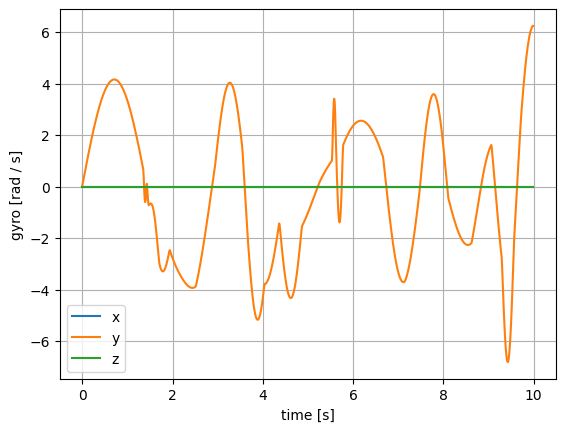

In [32]:
plt.grid()
plt.plot(np.arange(0, 10.0, step=sys.dt), imu_lower["gyr"], label=["x", "y", "z"])
plt.ylabel("gyro [rad / s]")
plt.xlabel("time [s]")
plt.legend()
plt.show()

As you can see it's a two-dimensional problem, which is why only one (`y`) is non-zero.

Let's consider a larger kinematic chain in free 3D space.

In [33]:
xml_str = """
<x_xy model="three_segment_kinematic_chain">
    <options gravity="0 0 9.81" dt="0.01"/>
    <worldbody>
        <body name="seg2" joint="free" pos="0 0 2">
            <geom type="box" mass="0.1" pos="0.5 0 0" dim="1 0.25 0.2"/>
            <body name="seg1" joint="ry">
                <geom type="box" mass="0.1" pos="-0.5 0 0" dim="1 0.25 0.2"/>
                <body name="imu1" joint="frozen" pos="-0.5 0 0.125">
                    <geom type="box" mass="0.05" dim="0.2 0.2 0.05" color="orange"/>
                </body>
            </body>
            <body name="seg3" joint="rz" pos="1 0 0">
                <geom type="box" mass="0.1" pos="0.5 0 0" dim="1 0.25 0.2"/>
                <body name="imu2" joint="frozen" pos="0.5 0 -0.125">
                    <geom type="box" mass="0.05" dim="0.2 0.2 0.05" color="orange"/>
                </body>
            </body>
        </body>
    </worldbody>
</x_xy>
"""

sys = ring.System.create(xml_str)
data = ring.RCMG(sys, ring.MotionConfig(T=10.0, t_max=1.5), add_X_imus=True,
                           add_y_relpose=True, keep_output_extras=True).to_list()

# with `keep_output_extras` really everything one could possibly imagine is returned
(X, y), (key, qs, xs, sys_mod) = data[0]

frames = sys.render(xs=xs, camera="targetfar")
show_video(frames, sys.dt)


Rendering frames..: 100%|██████████| 1000/1000 [00:06<00:00, 165.45it/s]


The two orange boxes on segment 1 and segment 3 are modelling our two IMUs. This will be the network's input `X` data.

As target we will try to estimate both relative orientations as `y` data.

In [34]:
X.keys()

dict_keys(['seg1', 'seg2', 'seg3'])

In [35]:
X["seg1"].keys()

dict_keys(['acc', 'gyr'])

In [36]:
y.keys()

dict_keys(['seg1', 'seg3'])

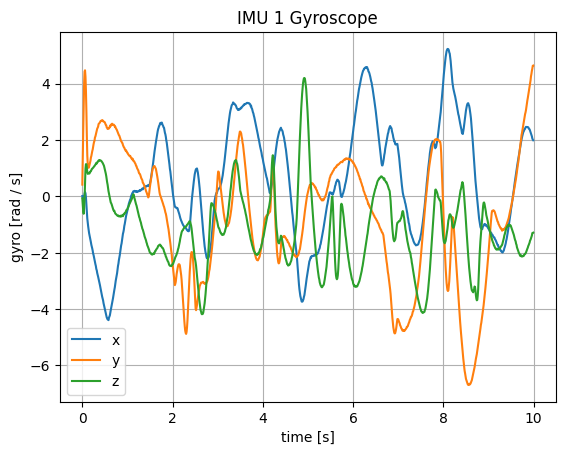

In [37]:
plt.grid()
plt.plot(np.arange(0, 10.0, step=sys.dt), X["seg1"]["gyr"], label=["x", "y", "z"])
plt.ylabel("gyro [rad / s]")
plt.xlabel("time [s]")
plt.title("IMU 1 Gyroscope")
plt.legend()
plt.show()


Now, the IMU is non-zero in all three `x/y/z` components.

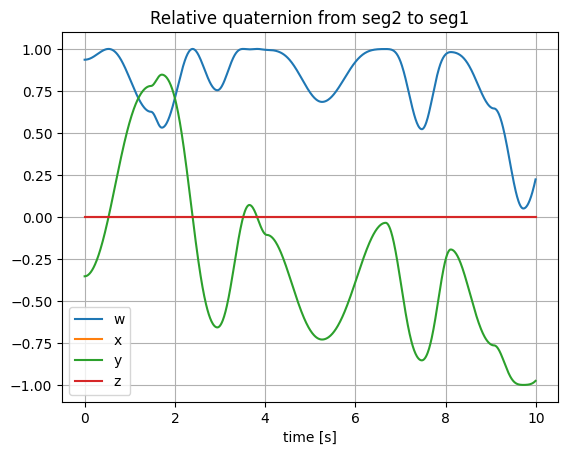

In [38]:
plt.grid()
plt.plot(np.arange(0, 10.0, step=sys.dt), y["seg1"], label=["w", "x", "y", "z"])
plt.xlabel("time [s]")
plt.title("Relative quaternion from seg2 to seg1")
plt.legend()
plt.show()


Note how the relative quaternion is only around the y-axis. Can you see why? (Hint: Check the defining `xml_str`.)